In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

In [77]:
eur_df = pd.read_csv(".\\data\\EURUSD=X.csv")

In [78]:
eur_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-06-17,1.199185,1.200769,1.190703,1.199559,1.199559,0
1,2021-06-18,1.191327,1.192748,1.185115,1.191341,1.191341,0
2,2021-06-21,1.186901,1.192051,1.184876,1.187366,1.187366,0
3,2021-06-22,1.191157,1.191753,1.188241,1.191256,1.191256,0
4,2021-06-23,1.193745,1.197000,1.191583,1.193673,1.193673,0


In [79]:
eur = eur_df["Close"] 
Date = pd.to_datetime(eur_df["Date"])

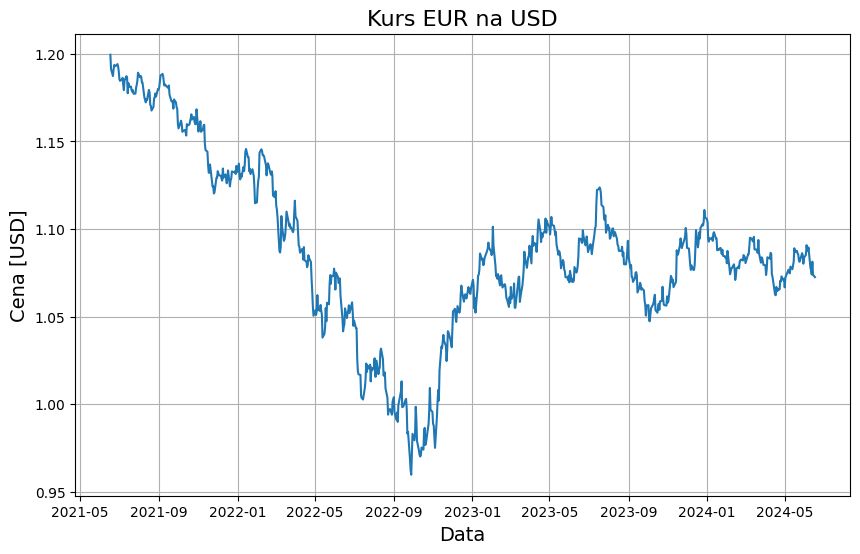

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(Date, eur, c="C0")
plt.title("Kurs EUR na USD", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena [USD]", fontsize=14)
plt.grid(True)
plt.show()

In [81]:
last_value = eur.iloc[-1]
last_value

1.072501

In [82]:
print(f'eur:\n{eur.isnull().sum()}\n\n')
print(f'date:\n{Date.isnull().sum()}')

eur:
0


date:
0


# opcje
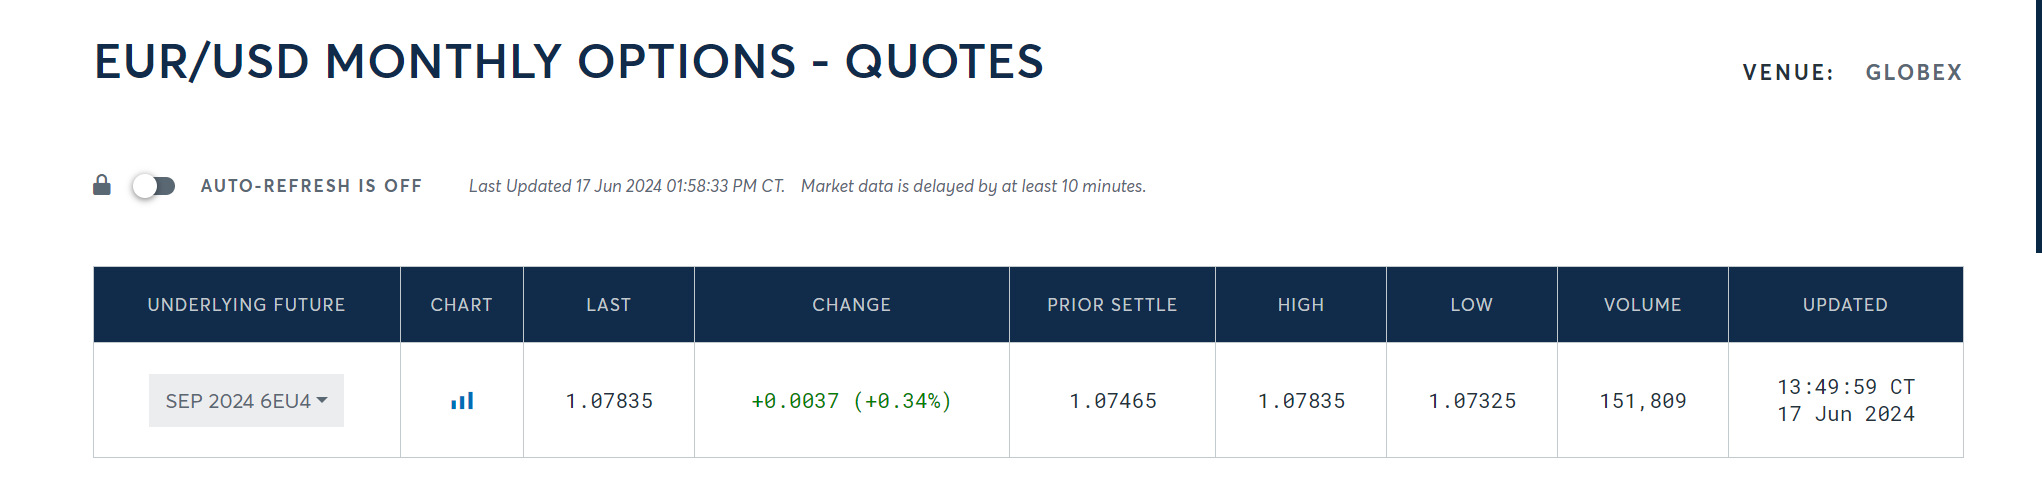

In [83]:
def black_scholes_put(S_0, K, r, sigma, t_0, T):
    T_t = (T - t_0).days/365
    # T_t = (T - t_0).days
    sqrt_T_t = np.sqrt(T_t)
    arg_1 = (-np.log(S_0 / K) - (r - (0.5 * sigma**2)) * T_t) / (sigma * sqrt_T_t)
    arg_2 = (-np.log(S_0 / K) - (r + (0.5 * sigma**2)) * T_t) / (sigma * sqrt_T_t)

    P =  K * np.exp(-r * T_t) * norm.cdf(arg_1) - S_0 * norm.cdf(arg_1) 
    return P, arg_1, arg_2



def Greek(S_0, K, r, sigma, arg_1, arg_2, t_0, T):
    T_t = (T - t_0).days/365
    # T_t = (T - t_0).days
    sqrt_T_t = np.sqrt(T_t)
    delta = norm.cdf(arg_1)
    gamma = norm.pdf(arg_1) / (S_0 * sigma * sqrt_T_t)
    vega = S_0 * norm.pdf(arg_1) * sqrt_T_t
    theta = -S_0 * norm.pdf(arg_1) * sigma / (2 * sqrt_T_t) - r * K * np.exp(-r * T_t) * norm.cdf(arg_2)
    rho = K * T_t * np.exp(-r * T_t) * norm.cdf(arg_2)
    return delta, gamma, vega, theta, rho

In [84]:
# Dane do wyceny opcji:
S_0 = eur.iloc[-1]
sigma = np.std(eur)
K = S_0 * (1 + 0.34/100) 
r = ((1 + 4.34/100)**(1/365)) - 1 # stopa rynkowa usa od dziewczyn
t_0 = pd.to_datetime("2024-06-17")
T = pd.to_datetime("2024-09-17") # 3 miesiace odstepu

In [85]:
data = {
    "Parametr": ["Cena obecna (S_0)", "Zmienność (sigma)", "Cena wykonania (K)", "Stopa procentowa (r)", "Czas obecny (t_0)", "Data wygaśniecią (T)"],
    "Wartość": [S_0, sigma, K, r, t_0, T]
}

df = pd.DataFrame(data)
df

,Parametr,Wartość
0,Cena obecna (S_0),1.072501
1,Zmienność (sigma),0.049617
2,Cena wykonania (K),1.076148
3,Stopa procentowa (r),0.000116
4,Czas obecny (t_0),2024-06-17 00:00:00
5,Data wygaśniecią (T),2024-09-17 00:00:00


# Opcja put do dalszej analizy

In [86]:
P, arg_1, arg_2 = black_scholes_put(S_0, K, r, sigma, t_0, T)

data_black_scholes = {
    "Parametr": ["P", "arg_1", "arg_2"],
    "Wartość": [P, arg_1, arg_2 ]
}

df_black_scholes = pd.DataFrame(data_black_scholes)
df_black_scholes

,Parametr,Wartość
0,P,0.002019
1,arg_1,0.147536
2,arg_2,0.122626


In [87]:
delta, gamma, vega, theta, rho = Greek(S_0, K, r, sigma, arg_1, arg_2, t_0, T)


data_greek = {
    "Parametr": ["delta", "gamma", "vega", "theta", "rho"],
    "Wartość": [delta, gamma, vega, theta, rho]
}

df_greek = pd.DataFrame(data_greek)
df_greek

,Parametr,Wartość
0,delta,0.558646
1,gamma,14.771007
2,vega,0.212485
3,theta,-0.020982
4,rho,0.148856


# Futures

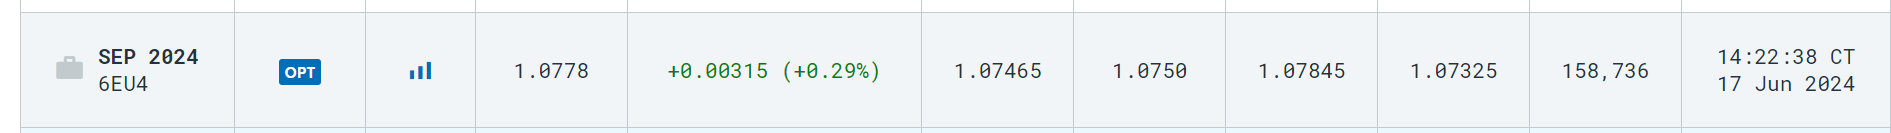

In [88]:
def Futures(S, T, t_0, r):
    T_t = (T - t_0).days/365
    # T_t = (T - t_0).days
    return S*np.exp(r*T_t)

In [89]:
futures = Futures(S_0, T, t_0, r)
print(futures)

# to sie zgadza z tym co znalazlam (ss)

print(f"Premia = {0.00315}")
# print(_0) #?

1.0725324675624655
Premia = 0.00315


# Strategia

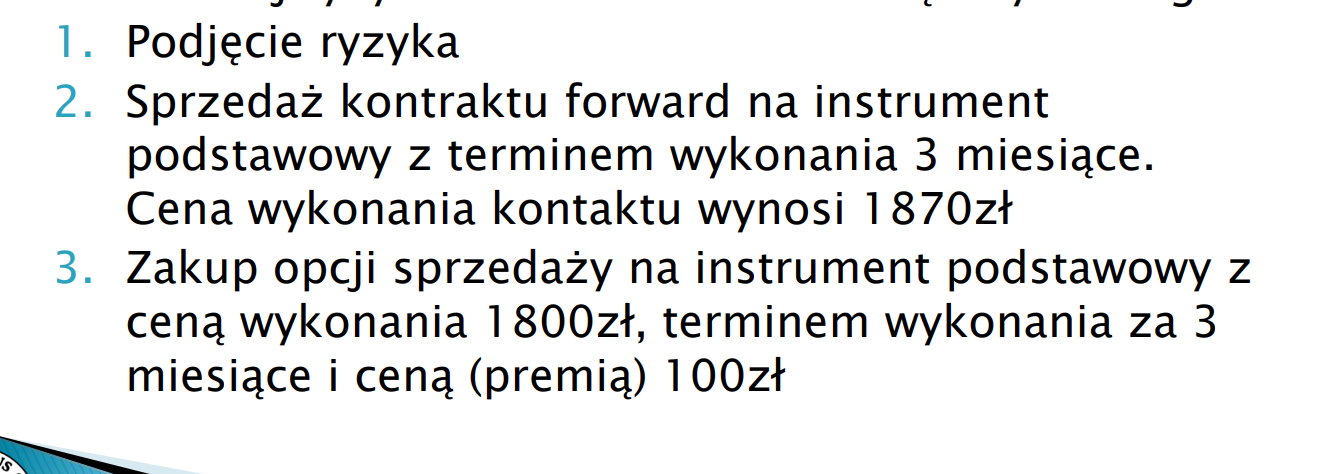

In [90]:
chosen_indexes = np.arange(10, len(eur), 100)
eur_price = np.sort(eur[chosen_indexes])
price_option = - P + [max(x, K) for x in eur_price]
price_forward = futures*np.ones(len(eur_price))

In [91]:
data_strategy = pd.DataFrame({
    "Bez zabezpieczenia": eur_price,
    "Zabezpieczenie kontraktem forward": price_forward,
    "Zabezpieczenie opcją sprzedaży": price_option
})

data_strategy

,Bez zabezpieczenia,Zabezpieczenie kontraktem forward,Zabezpieczenie opcją sprzedaży
0,0.996910,1.072532,1.074128
1,1.053852,1.072532,1.074128
2,1.069519,1.072532,1.074128
3,1.076600,1.072532,1.074581
4,1.089823,1.072532,1.087804
5,1.089954,1.072532,1.087935
6,1.132118,1.072532,1.130099
7,1.185677,1.072532,1.183658


In [92]:
eur_price_all = np.linspace(np.min(eur), np.max(eur), 100)
price_option_all = - P + [max(x, K) for x in eur_price_all]
price_forward_all = futures*np.ones(len(eur_price_all))

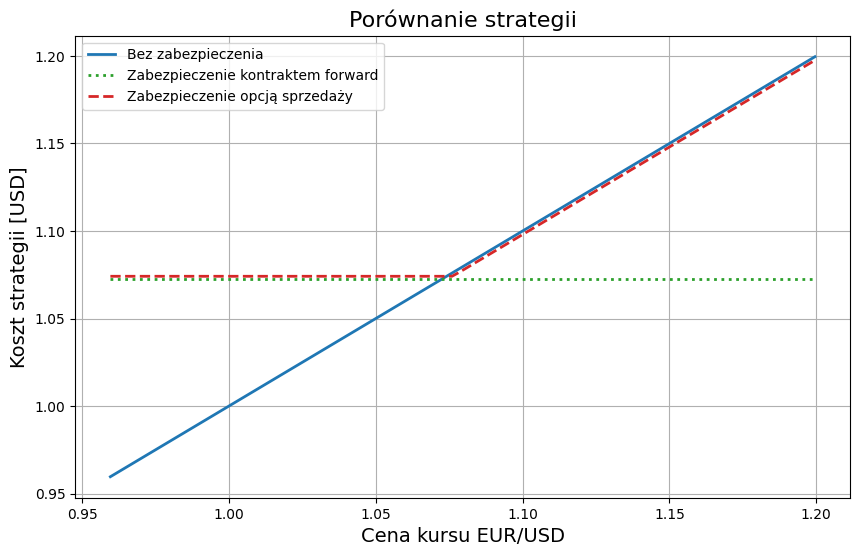

In [93]:
plt.figure(figsize=(10, 6))

plt.plot(eur_price_all, eur_price_all , label='Bez zabezpieczenia', c="C0", linewidth=2)
plt.plot(eur_price_all, price_forward_all, label='Zabezpieczenie kontraktem forward', linestyle = "dotted", c="C2", linewidth=2)
plt.plot(eur_price_all, price_option_all, label='Zabezpieczenie opcją sprzedaży', linestyle = "dashed", c="C3", linewidth=2)

plt.xlabel('Cena kursu EUR/USD', fontsize=14)
plt.ylabel('Koszt strategii [USD]', fontsize=14)
plt.title('Porównanie strategii', fontsize=16)

plt.legend()
plt.grid(True)

plt.show()

# Portfel

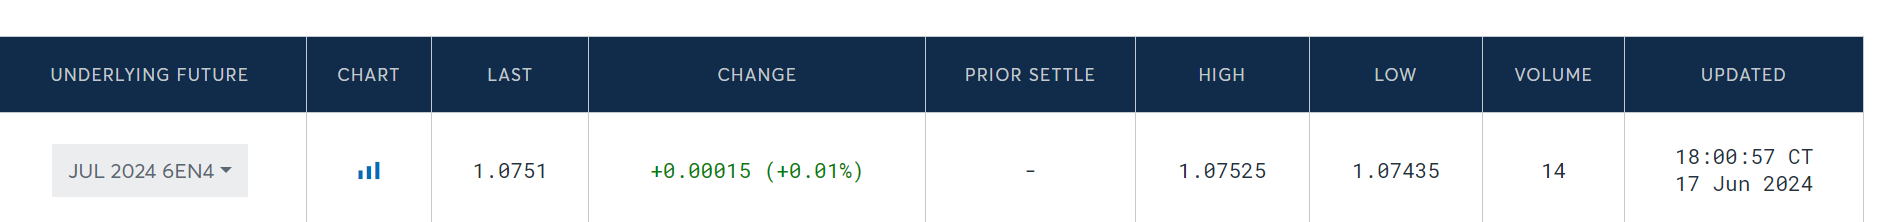
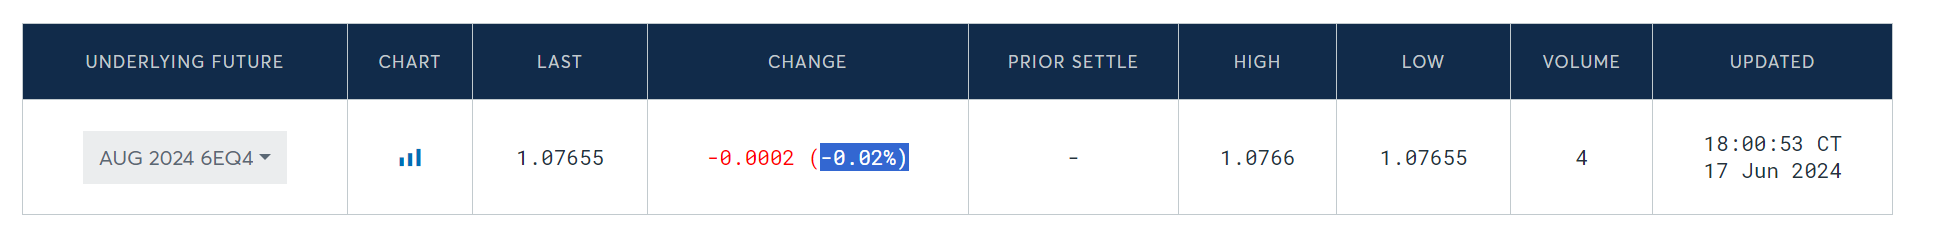

In [94]:
# Dane do wyceny opcji:
K_2 = S_0 * (1 + 0.01/100) 
T_2 = pd.to_datetime("2024-07-17")

K_3 = S_0 * (1 - 0.02/100) 
T_3 = pd.to_datetime("2024-08-17")

num = 100 # akcji

In [95]:
P_2, arg_1_2, arg_2_2 = black_scholes_put(S_0, K_2, r, sigma, t_0, T_2)
delta_2, gamma_2, vega_2, theta_2, rho_2 = Greek(S_0, K_2, r, sigma, arg_1_2, arg_2_2, t_0, T_2)

P_3, arg_1_3, arg_2_3 = black_scholes_put(S_0, K_3, r, sigma, t_0, T_3)
delta_3, gamma_3, vega_3, theta_3, rho_3 = Greek(S_0, K_3, r, sigma, arg_1_3, arg_2_3, t_0, T_3)

In [96]:
data_greek = {
    "Parametr": ["delta", "gamma", "vega", "theta", "rho"],
    "A": [delta, gamma, vega, theta, rho],
    "B": [delta_2, gamma_2, vega_2, theta_2, rho_2],
    "C": [delta_3, gamma_3, vega_3, theta_3, rho_3]
}

df_greek = pd.DataFrame(data_greek)
df_greek

,Parametr,A,B,C
0,delta,0.558646,0.505373,0.499729
1,gamma,14.771007,26.147528,18.338577
2,vega,0.212485,0.122654,0.174915
3,theta,-0.020982,-0.037084,-0.026026
4,rho,0.148856,0.044053,0.088102


In [97]:
coefficients = np.array([
    [delta, delta_2, delta_3],
    [gamma, gamma_2, gamma_3],
    [vega, vega_2, vega_3]
])
constants = np.array([-100, 0, 0])

solutions = np.linalg.solve(coefficients, constants)
print(f"Rozwiązania: {solutions}")
# a i b sprzedajemy a c kupujemy 

Rozwiązania: [-2556.8001236  -1444.36262242  4118.80499524]


# VAR

In [98]:
var_p_1 = round(np.quantile(eur_price_all, 0.05), 6)
var_p_2 = round(np.quantile(price_forward_all, 0.05), 6)
var_p_3 = round(np.quantile(price_option_all, 0.05), 6)

print(f'VaR wartości portfela 95% - brak strategii: {var_p_1}')
print(f'VaR wartości portfela 95% - zabezpieczenie futures: {var_p_2}')
print(f'VaR wartości portfela 95% - zabezpieczenie opcją: {var_p_3}\n\n')

var_p_1 = round(np.quantile(eur_price_all, 0.01), 6)
var_p_2 = round(np.quantile(price_forward_all, 0.01), 6)
var_p_3 = round(np.quantile(price_option_all, 0.01), 6)

print(f'VaR wartości portfela 99% - brak strategii: {var_p_1}')
print(f'VaR wartości portfela 99% - zabezpieczenie futures: {var_p_2}')
print(f'VaR wartości portfela 99% - zabezpieczenie opcją: {var_p_3}')

VaR wartości portfela 95% - brak strategii: 0.971616
VaR wartości portfela 95% - zabezpieczenie futures: 1.072532
VaR wartości portfela 95% - zabezpieczenie opcją: 1.074128


VaR wartości portfela 99% - brak strategii: 0.962018
VaR wartości portfela 99% - zabezpieczenie futures: 1.072532
VaR wartości portfela 99% - zabezpieczenie opcją: 1.074128


In [99]:
var_p_1 = round(np.quantile(eur_price, 0.05), 6)
var_p_2 = round(np.quantile(price_forward, 0.05), 6)
var_p_3 = round(np.quantile(price_option, 0.05), 6)

print(f'VaR wartości portfela 95% - brak strategii: {var_p_1}')
print(f'VaR wartości portfela 95% - zabezpieczenie futures: {var_p_2}')
print(f'VaR wartości portfela 95% - zabezpieczenie opcją: {var_p_3}\n\n')

var_p_1 = round(np.quantile(eur_price, 0.01), 6)
var_p_2 = round(np.quantile(price_forward, 0.01), 6)
var_p_3 = round(np.quantile(price_option, 0.01), 6)

print(f'VaR wartości portfela 99% - brak strategii: {var_p_1}')
print(f'VaR wartości portfela 99% - zabezpieczenie futures: {var_p_2}')
print(f'VaR wartości portfela 99% - zabezpieczenie opcją: {var_p_3}')

VaR wartości portfela 95% - brak strategii: 1.01684
VaR wartości portfela 95% - zabezpieczenie futures: 1.072532
VaR wartości portfela 95% - zabezpieczenie opcją: 1.074128


VaR wartości portfela 99% - brak strategii: 1.000896
VaR wartości portfela 99% - zabezpieczenie futures: 1.072532
VaR wartości portfela 99% - zabezpieczenie opcją: 1.074128


In [100]:
# ŹRÓDŁA DANYCH (futures i options)s
# https://www.cmegroup.com/markets/fx/g10/euro-fx.html
# https://www.cmegroup.com/markets/fx/g10/euro-fx.quotes.html
# https://www.cmegroup.com/markets/fx/fx-product-guide.html#futures
# https://www.cmegroup.com/markets/fx/g10/euro-fx.quotes.options.html#optionProductId=8116&strikeRange=ATM